In [1]:
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


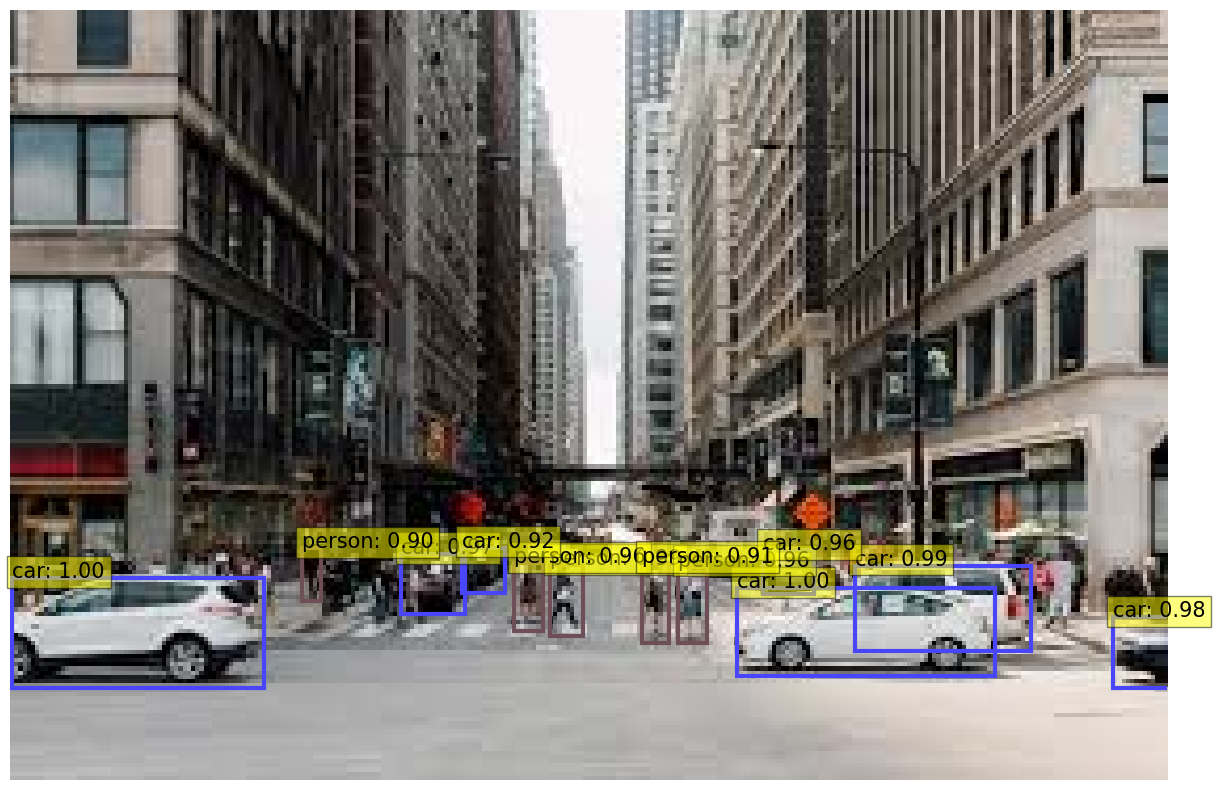

In [1]:
import io
import torch
import logging
import numpy as np
import torchvision.models as models
from matplotlib import pyplot as plt
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image

# Suppress unnecessary warnings
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
# logging.getLogger().setLevel(logging.INFO)

class DetrObjectDetection:
    def __init__(self, model_name="facebook/detr-resnet-50", threshold=0.9):
        # Load the pretrained DETR model and processor
        self.processor = DetrImageProcessor.from_pretrained(model_name)
        self.model = DetrForObjectDetection.from_pretrained(model_name)
        self.threshold = threshold

        # COCO_CLASSES for mapping detected labels to human-readable names
        self.COCO_CLASSES = [
            "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus",
            "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign",
            "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
            "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag",
            "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
            "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
            "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
            "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza",
            "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table",
            "toilet", "TV", "laptop", "mouse", "remote", "keyboard", "cell phone",
            "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock",
            "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
        ]

    def load_image(self, image_path):
        # Open the image and convert it to RGB
        self.image = Image.open(image_path).convert("RGB")
        return self.image

    def preprocess_image(self):
        # Preprocess the image
        self.inputs = self.processor(images=self.image, return_tensors="pt")
        return self.inputs

    def run_inference(self):
        # Perform inference
        self.model.eval()
        with torch.no_grad():
            self.outputs = self.model(**self.inputs)
        return self.outputs

    def process_outputs(self):
        # Process model outputs
        target_sizes = torch.tensor([self.image.size[::-1]])  # Original image size (H, W)
        self.results = self.processor.post_process_object_detection(self.outputs, target_sizes=target_sizes, threshold=self.threshold)
        return self.results

    def print_results(self):
        # Print detected objects with labels, scores, and bounding boxes
        for result in self.results:
            logging.info("Detected objects:")
            for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
                class_name = self.COCO_CLASSES[label]  # Get the class name
                logging.info(f"Class: {class_name}, Score: {score:.2f}, Box: {box.tolist()}")

    def visualize_prediction(self, filtered_preds):
        # Visualization code
        id2label = self.model.config.id2label  # Access id2label from the model's config
        keep = filtered_preds["scores"] > self.threshold
        boxes = filtered_preds["boxes"][keep].tolist()
        scores = filtered_preds["scores"][keep].tolist()
        labels = filtered_preds["labels"][keep].tolist()

        color_map = {}
        for label in set(labels):
            color_map[label] = np.random.rand(3)

        plt.figure(figsize=(16, 10))
        plt.imshow(self.image)
        ax = plt.gca()
        for score, (xmin, ymin, xmax, ymax), label in zip(scores, boxes, labels):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=color_map[label], linewidth=3))
            ax.text(xmin, ymin, f"{self.COCO_CLASSES[label]}: {score:.2f}", fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))
        plt.axis("off")
        return self.fig2img(plt.gcf())

    def fig2img(self, fig):
        # Convert the figure to an image
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        return img

    def detect(self, image_path):
        self.load_image(image_path)
        self.preprocess_image()
        self.run_inference()
        self.process_outputs()
        # self.print_results()
        # Optionally, visualize the first result
        visualized_image = self.visualize_prediction(self.results[0])
        # visualized_image.show()  # Displays the visualized image

# Example usage:

detector = DetrObjectDetection()
detector.detect("images.jpeg")